In [2]:
import os,sys
sys.path.append('/home/cs341seti/cs341-ibm-seti/')
import numpy as np
import requests
import json
import pandas as pd
import ibmseti
import collections
import scipy.io
import matplotlib.pyplot as plt
import commonutils as cu
import PIL
from PIL import Image
from scipy import signal
import model_specs

Using TensorFlow backend.


In [3]:
import keras
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

In [5]:
base_url = 'https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b'
container = 'simsignals'
fname = '000739aa-89d6-4965-abf6-9b46a246604a.dat'
r = requests.get('{}/{}/{}'.format(base_url, container, fname))

In [211]:
r = requests.get('https://dal.objectstorage.open.softlayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b/simsignals_files/public_list_headers_3april_2017.txt')
fileList = r.text.split('\n')[:-1]
fileListJSON = [json.loads(entry) for entry in fileList]
fileListJSON[0]

{u'file_name': u'00069203-0824-4136-9c99-b9f68672f23d.dat',
 u'signal_classification': u'squigglesquarepulsednarrowband',
 u'uuid': u'00069203-0824-4136-9c99-b9f68672f23d'}

# Try out Welch spectrogram generation

In [5]:
def showImageFromSpec(spec,imsize,binFactor,colmap,columnNorm=False,save=False,filename=None):
    specShape = spec.shape
    spec = cu.nputils.bin_ndarray(spec[1:,:],(specShape[0]-1,specShape[1]/binFactor),operation='average')
    dpi = 96.0
    fig = plt.figure(frameon=False,figsize=(imsize[0]/dpi,imsize[1]/dpi))
    ax = plt.Axes(fig,[0.,0.,1.,1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    # fig, ax = plt.subplots(figsize=(20, 10))
    # ax.imshow(np.log(spec), aspect = 0.5*float(spec.shape[1]) / spec.shape[0])
    plt.set_cmap(colmap)
    psd = np.log(spec)
    #psd = spec
    if columnNorm:
        psd = psd - np.median(psd,axis=0)
        psd = psd.clip(min=0)
    ax.imshow(psd, aspect = 'auto')
    plt.show()

def welchPSD(aca,target_size):
    originalSignal = aca.complex_data()
    full_signal_len = len(originalSignal)
    # Generate spectrogram with extra columns and eliminate
    # to get rid of some line caused by welch
    nExtraCols = 2
    # Number of chunks signal is broken into by welch
    windowFactor = full_signal_len//np.prod(target_size)
    print "Using window factor: %d" % windowFactor
    # Fitting an appropriate signal length (possibly buggy, not tested for all input sizes)
    spec_input_size = (target_size[0],full_signal_len//target_size[0])
    clipped_signal_len = np.prod(spec_input_size)
    # Break signal into time slices
    reshapedSignal = aca._reshape(originalSignal[0:clipped_signal_len],spec_input_size)
    psd = signal.welch(reshapedSignal,nperseg=target_size[1]+nExtraCols,return_onesided=False)[1]
    # Removing some arbitrary line that appears by getting rid of cols at both edges
    psd = psd[:,1:(target_size[1]+1)]
    # Correcting for some 90 degree rotation caused by welch
    psd = np.roll(psd,target_size[1]//2+1,axis=1)
    return psd

In [8]:
fileListDF = pd.read_csv('../data/fileList.csv',dtype={'file_index':str})
fileListDF[fileListDF['signal_classification']=='squarepulsednarrowband'].head()

,file_name,signal_classification,uuid,file_index,label,dataset
9,001f3507-f359-4822-8d16-b7320caf2a9e.dat,squarepulsednarrowband,001f3507-f359-4822-8d16-b7320caf2a9e,000009,4,train
19,003e7672-f67f-494a-8991-45eac1b6bdfe.dat,squarepulsednarrowband,003e7672-f67f-494a-8991-45eac1b6bdfe,000019,4,train
49,00b5d26e-1002-44d6-b88d-a03627af5abe.dat,squarepulsednarrowband,00b5d26e-1002-44d6-b88d-a03627af5abe,000049,4,train
53,00d04012-9264-4758-a864-839956489070.dat,squarepulsednarrowband,00d04012-9264-4758-a864-839956489070,000053,4,train
55,00d41037-194d-44eb-9394-3f2b7b450ccf.dat,squarepulsednarrowband,00d41037-194d-44eb-9394-3f2b7b450ccf,000055,4,train


In [9]:
fid = '014809'
fileStrBuffer = open('../data/SETIsignals_raw/{}.dat'.format(fid), 'r').read()
aca = ibmseti.compamp.SimCompamp(fileStrBuffer)
fileListDF[fileListDF['file_index']==fid]

,file_name,signal_classification,uuid,file_index,label,dataset
14809,ed08763d-84cc-44f5-8676-e2cd8fc5cb23.dat,narrowbanddrd,ed08763d-84cc-44f5-8676-e2cd8fc5cb23,014809,3,test


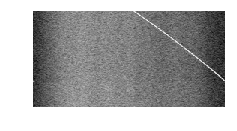

In [12]:
imsize = (128,256)
showImageFromSpec(cu.datautils.welchPSD(aca,imsize),imsize=(imsize[1],imsize[0]),binFactor=1,colmap='gray',columnNorm=False)

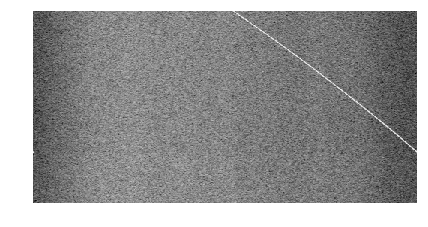

In [13]:
imsize = (256,512)
showImageFromSpec(cu.datautils.welchPSD(aca,imsize),imsize=(imsize[1],imsize[0]),binFactor=1,colmap='gray',columnNorm=False)

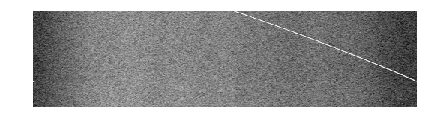

In [15]:
imsize = (128,512)
showImageFromSpec(cu.datautils.welchPSD(aca,imsize),imsize=(imsize[1],imsize[0]),binFactor=1,colmap='gray',columnNorm=False)

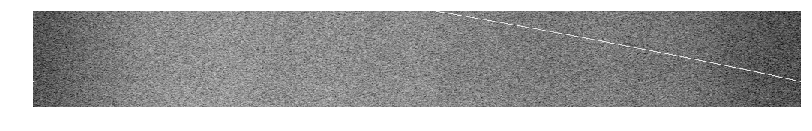

In [16]:
imsize = (128,1024)
showImageFromSpec(cu.datautils.welchPSD(aca,imsize),imsize=(imsize[1],imsize[0]),binFactor=1,colmap='gray',columnNorm=False)

In [20]:
fid = '015834'
fileStrBuffer = open('../data/SETIsignals_raw/{}.dat'.format(fid), 'r').read()
aca = ibmseti.compamp.SimCompamp(fileStrBuffer)
fileListDF[fileListDF['file_index']==fid]

,file_name,signal_classification,uuid,file_index,label,dataset
15834,fd8d65da-4fba-41ec-9e10-dcab8c7b4020.dat,narrowband,fd8d65da-4fba-41ec-9e10-dcab8c7b4020,015834,2,test


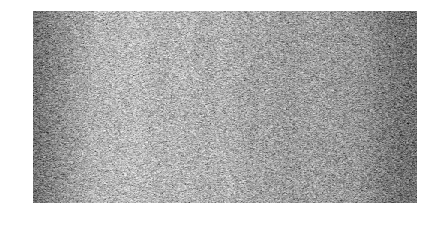

In [25]:
imsize = (256,512)
showImageFromSpec(cu.datautils.welchPSD(aca,imsize),imsize=(imsize[1],imsize[0]),binFactor=1,colmap='gray',columnNorm=False)

In [240]:
ibmfname = fileListDF['file_name'].loc[fileListDF['file_index']==fid].values[0]
[ f for f in fileListJSON if f['file_name'] == ibmfname ]

[{u'file_name': u'001f3507-f359-4822-8d16-b7320caf2a9e.dat',
  u'signal_classification': u'squarepulsednarrowband',
  u'uuid': u'001f3507-f359-4822-8d16-b7320caf2a9e'}]

In [239]:
ibmfname = fileListDF['file_name'].loc[fileListDF['file_index']==fid].values[0]
ibmfname

'001f3507-f359-4822-8d16-b7320caf2a9e.dat'

# Converting and saving as images

In [ ]:
# Run through directory 
datPath = "../data/SETIsignals_raw/"
image_size = (256,512)
windowFactor = 6
savePath = "../data/welch_specdataimages_gray_{}x{}_{}/".format(image_size[0],image_size[1],windowFactor)
os.system("mkdir -p "+savePath)
datfiles = [f for f in os.listdir(datPath) if os.path.isfile(os.path.join(datPath, f))]
for i in range(len(datfiles)):
    # Convert and save each file as image
    fid = datfiles[i].split(".")[0]
    print "\r{0}".format(i),
    fileStrBuffer = open('{}{}.dat'.format(datPath,fid), 'r').read()
    aca = ibmseti.compamp.SimCompamp(fileStrBuffer)
    spec = cu.datautils.welchPSD(aca,image_size)
    cu.datautils.saveImageFromSpec(spec,image_size,binFactor=1,colmap='gray',
                                   save=True,filename="{}{}".format(savePath,fid))

# Reorganising image files into train/val/test folders

In [4]:
# Loading in table with info on files
fileListDF = pd.read_csv("../data/fileList.csv",dtype={'file_index':str})
fileListDF.groupby(['dataset','signal_classification']).agg('count')

file_name  uuid  file_index  label
dataset    signal_classification                                             
test       brightpixel                           200   200         200    200
           narrowband                            185   185         185    185
           narrowbanddrd                         349   349         349    349
           noise                                 185   185         185    185
           squarepulsednarrowband                192   192         192    192
           squiggle                              186   186         186    186
           squigglesquarepulsednarrowband        203   203         203    203
train      brightpixel                          1497  1497        1497   1497
           narrowband                           1531  1531        1531   1531
           narrowbanddrd                        3018  3018        3018   3018
           noise                                1526  1526        1526   1526
           squarepulsednarrowband               1503  1503        1503   1503
           squiggle                             1509  1509        1509   1509
           squigglesquarepulsednarrowband       1501  1501        1501   1501
validation brightpixel                           303   303         303    303
           narrowband                            281   281         281    281
           narrowbanddrd                         628   628         628    628
           noise                                 287   287         287    287
           squarepulsednarrowband                303   303         303    303
           squiggle                              302   302         302    302
           squigglesquarepulsednarrowband        296   296         296    296

In [5]:
sourceDir = "../data/welch_specdataimages_gray_256x512_6/"
destDir = "../data/welch_imagesDataset_256x512_6/"

os.system("mkdir -p "+destDir)
for i in fileListDF[fileListDF['dataset']=='train'].index:
    labelDir = "{}-{}".format(fileListDF['label'].ix[i],fileListDF['signal_classification'].ix[i])
    os.system("mkdir -p "+os.path.join(destDir,"train",labelDir))
    fname = os.path.join(sourceDir,"{}.jpg".format(fileListDF['file_index'].ix[i]))
    os.system("cp {} {}".format(fname,os.path.join(destDir,"train",labelDir)))
    print "\rTraining: {}".format(i),
for i in fileListDF[fileListDF['dataset']=='validation'].index:
    labelDir = "{}-{}".format(fileListDF['label'].ix[i],fileListDF['signal_classification'].ix[i])
    os.system("mkdir -p "+os.path.join(destDir,"validation",labelDir))
    fname = os.path.join(sourceDir,"{}.jpg".format(fileListDF['file_index'].ix[i]))
    os.system("cp {} {}".format(fname,os.path.join(destDir,"validation",labelDir)))
    print "\rValidation: {}".format(i),
for i in fileListDF[fileListDF['dataset']=='test'].index:
    labelDir = "{}-{}".format(fileListDF['label'].ix[i],fileListDF['signal_classification'].ix[i])
    os.system("mkdir -p "+os.path.join(destDir,"test",labelDir))
    fname = os.path.join(sourceDir,"{}.jpg".format(fileListDF['file_index'].ix[i]))
    os.system("cp {} {}".format(fname,os.path.join(destDir,"test",labelDir)))
    print "\rTest: {}".format(i),

Test: 15984 14484                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               


# Creating a single h5 dataset file for evaluation

In [ ]:
## Read in all files from directory and combine them into train/val/test datasets
readDir = "../data/specdataimages_gray_512x256_8/"
cu.datautils.createDataset(readDir,"../data/fileList.csv",
                           '../data/imagesDataset_512x256_8/imagesDataset_512x256_8.h5',
                           loadImages=True,grayscale=True)